# Can we classify open clusters and globular clusters using their B-V index and true diameter?

## Abstract

## Introduction

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn import metrics
import sklearn as sk

## Reading the Data

In [2]:
## Functions to calculate diameter of clusters
def get_angular_size(r_h):
	'''Go  from half light radius to true radius, based on King (1966) model for half light radius.
	Takes half light radius, in arcmin, and multiply by 2.5 to get angular radius.
	Multiply by 2 again to get angular diameter (angular size)
	'''
	return 2.5 * r_h * 2


def get_true_diameter(angular_size, dist):
	'''Takes angular size, in arcmin, and distance from Sun, in pc,
	Calculates true diameter (in pc)
	'''
	diam_rad = angular_size * (2.9089 * 10**-4) # 2.9089 * 10^-4 rad = 1 arcmin
	return diam_rad * dist 


In [3]:
def get_angular_size(r_h):
	'''Go  from half light radius to true radius, based on King (1966) model for half light radius.
	Takes half light radius, in arcmin, and multiply by 2.5 to get angular radius.
	Multiply by 2 again to get angular diameter (angular size)
	'''
	return 2.5 * r_h * 2


def get_true_diameter(angular_size, dist):
	'''Takes angular size, in arcmin, and distance from Sun, in pc,
	Calculates true diameter (in pc)
	'''
	diam_rad = angular_size * (2.9089 * 10**-4) # 2.9089 * 10^-4 rad = 1 arcmin
	return diam_rad * dist 


# GLOBULAR CLUSTER DATA READING
glob_data1 = pd.read_csv("glob_data.txt", skiprows = 72, nrows = 157, delim_whitespace = True, header = None)
glob_data2 = pd.read_csv("glob_data.txt", skiprows = 252, nrows = 157, delim_whitespace = True, header = None)
glob_data3 = pd.read_csv("glob_data.txt", skiprows = 433, nrows = 157, delim_whitespace = True, header = None)

# Combining the first two columns because the names were split
glob_data1["Cname"] = glob_data1.iloc[:,0] + glob_data1.iloc[:,1].astype(str)


glob_data = pd.concat([glob_data1["Cname"], glob_data1.iloc[:,4:10], glob_data1.iloc[:,10], glob_data2.iloc[:,4], glob_data3.iloc[:,9]], axis = 1)
glob_data.columns = ["Cname", "RA1", "RA2","RA3", "Dec1", "Dec2", "Dec3", "R_sun", "E(B-V)","r_h" ]
glob_data = glob_data.dropna()

# OPEN CLUSTER DATA READING
open_data = pd.read_csv("open_data.tsv", skiprows = 39, delimiter = "\t", header = None)

# Code generated by ChatGPT-4o (OpenAI, 2024) - November 2024 version, Prompt: "I have too many whitespace missing values in my dataset, how do I remove them?"
open_data = open_data.applymap(lambda x: x.strip() if isinstance(x, str) else x)  # Remove leading/trailing spaces
open_data.replace('', pd.NA, inplace=True)  # Replace empty strings with NaN
open_data = open_data.dropna()

open_data.columns = ["RA", "Dec", "Diam", "Dist", "Age (log years)", "Metallicity", "E(B-V)", "Cname", "_RA.icrs", "_DE.icrs"]

print("Globular Data","\n")
print(glob_data.head())

print("Open Data", "\n")
print(open_data)

Globular Data 

     Cname    RA1  RA2   RA3  Dec1    Dec2   Dec3  R_sun  E(B-V)   r_h
0   NGC104   5.67  -72   4.0  52.6  305.89 -44.89    4.5    0.04  3.17
1   NGC288  45.24  -26  34.0  57.4  152.30 -89.38    8.9    0.03  2.23
2   NGC362  14.26  -70  50.0  55.6  301.53 -46.25    8.6    0.05  0.82
4  NGC1261  16.21  -55  12.0  58.4  270.54 -52.12   16.3    0.01  2.99
5     Pal1  20.04   79  34.0  51.8  130.06  19.03   11.1    0.15  3.51
Open Data 

          RA     Dec  Diam  Dist Age (log years) Metallicity E(B-V)  \
4    00 01.7  -30 12  89.0   190            7.70        0.03   0.09   
26   00 39.4  +85 04  13.0  1550            9.70       -0.06   0.04   
42   01 26.1  +63 03   4.4   900            9.10       -0.76   0.90   
60   01 54.8  +37 26  49.0   400            9.04       -0.21   0.02   
86   02 38.8  +42 34  35.0   440            8.29       -0.26   0.04   
..       ...     ...   ...   ...             ...         ...    ...   
909  20 32.5  +28 08  31.0   800            9.04 

/tmp/ipykernel_923621/3215036355.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  glob_data1 = pd.read_csv("glob_data.txt", skiprows = 72, nrows = 157, delim_whitespace = True, header = None)
/tmp/ipykernel_923621/3215036355.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  glob_data2 = pd.read_csv("glob_data.txt", skiprows = 252, nrows = 157, delim_whitespace = True, header = None)
/tmp/ipykernel_923621/3215036355.py:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  glob_data3 = pd.read_csv("glob_data.txt", skiprows = 433, nrows = 157, delim_whitespace = True, header = None)
/tmp/ipykernel_923621/3215036355.py:34: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map ins

### Clean Data and Change Types

In [4]:
# Change open_data variables from objects
open_data['Diam'] = pd.to_numeric(open_data['Diam'], errors = "coerce")
open_data['Dist'] = pd.to_numeric(open_data['Dist'], errors = "coerce")

# Mask out negatives from glob_data
glob_data = glob_data.mask(glob_data['r_h'] < 0)

### Calculate the True Diameter (in parsecs)

In [5]:
# glob_data true diameter
glob_data['true diam'] = get_true_diameter(get_angular_size(glob_data['r_h']), 1000 * glob_data['R_sun'])

# open_data true diameter
open_data['true diam'] = get_true_diameter(open_data['Diam'], open_data['Dist'])

### Combine Datasets

In [6]:
# Add cluster_type column
glob_data['cluster_type'] = 1 #making globular clusters equal to one
open_data['cluster_type'] = 0 #making open clusters equal to zero

# Drop unwanted columns
glob_data_dropped = glob_data.drop(columns = ['Cname', 'RA1', 'RA2', 'RA3', 'Dec1', 'Dec2', 'Dec3', 'R_sun', 'r_h'])
open_data_dropped = open_data.drop(columns = ['RA', 'Dec', 'Diam', 'Dist', 'Age (log years)', 'Metallicity', 'Cname', '_RA.icrs', '_DE.icrs'])

# Rename diameter columns 
glob_data_dropped.rename(columns = {'true diam': 'diameter (pc)'}, inplace = True)
open_data_dropped.rename(columns = {'true diam': 'diameter (pc)'}, inplace = True)

# Combine datasets
clusters_df = pd.concat([glob_data_dropped, open_data_dropped])

# Drop extreme values
clusters_df = clusters_df.mask((clusters_df['diameter (pc)'] > 1000))

# Drops Nans
clusters_df = clusters_df.dropna()

### More Dataset Maintenance 

In [7]:
# Make sure there are no objects
clusters_df = clusters_df.apply(pd.to_numeric, errors = 'raise')

# Checking for infinite or nans
print(clusters_df.isna().sum())

print(np.isinf(clusters_df).sum())

pd.set_option('display.max_rows', None)

#print(cluster_df['diameter']
print(glob_data['true diam'])
print(glob_data.isna().sum())

E(B-V)           0
diameter (pc)    0
cluster_type     0
dtype: int64
E(B-V)           0
diameter (pc)    0
cluster_type     0
dtype: int64
0        20.747729
1        28.866469
2        10.256781
4        70.885530
5        56.666826
6         5.380011
7      1268.425845
8       160.617822
9         8.975411
10       12.195563
11       45.553374
12      106.922437
15       11.170176
17        1.345366
18       22.093096
19       17.390859
21       13.474025
22       17.377769
23       33.917774
24       22.621061
25       28.798110
26       34.105398
27       66.052392
28       37.815700
29       34.269751
30       12.422457
32       53.523760
33      133.047268
34       20.362300
35       46.757659
36       21.009530
37       92.119045
38       27.816356
39       19.307824
40       45.804994
41       13.721281
43       51.580615
45      135.743819
46        8.872145
47       13.855091
48       36.957575
49       29.902038
50       68.602043
51       21.706212
52       16.103670
54   

## Ploting The Data

/tmp/ipykernel_923621/62755807.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


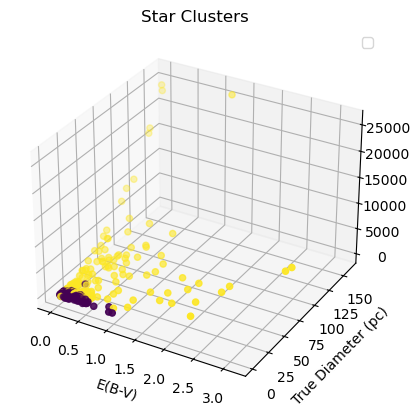

In [8]:
# Calculate z-values
z_values = (clusters_df['E(B-V)'])**2 + (clusters_df['diameter (pc)'])**2

# Plot
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
ax.scatter3D(clusters_df['E(B-V)'], clusters_df['diameter (pc)'], z_values, c = clusters_df['cluster_type'])
plt.title('Star Clusters')
plt.xlabel('E(B-V)')
plt.ylabel('True Diameter (pc)')
plt.legend()

## Logistic Regression

### Create and Run Model

In [9]:
# Creating features and labels to train model
clust = clusters_df
features = clust.iloc[:,0:2]
label = clust['cluster_type']

# Defining model
train_vectors, test_vectors, train_labels, test_labels = sk.model_selection.train_test_split(features, label, test_size = 0.25, train_size = 0.75, random_state = 0)

# Training model
logit_model = sm.Logit(train_labels, sm.add_constant(train_vectors))
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.172415
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:           cluster_type   No. Observations:                  159
Model:                          Logit   Df Residuals:                      156
Method:                           MLE   Df Model:                            2
Date:                Fri, 15 Nov 2024   Pseudo R-squ.:                  0.7326
Time:                        13:10:17   Log-Likelihood:                -27.414
converged:                       True   LL-Null:                       -102.54
Covariance Type:            nonrobust   LLR p-value:                 2.371e-33
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -7.2803      1.594     -4.569      0.000     -10.404      -4.157
E(B-V)            4

### Prediction and Accuracy

In [10]:
# Predict data
prediction = result.predict(sm.add_constant(test_vectors))

# Accuracy of prediction
#accuracy = accuracy_score(test_labels, prediction)
#print(f'Accuracy: {accuracy}')